In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
TEST = 'deepspeech_4'
LOG_FILE = f'results/{TEST}/avg_log.csv'

log_file = open(LOG_FILE, 'r')

# Read the log file into a DataFrame
metrics_df = pd.read_csv(log_file)

# Convert the timestamp to datetime
metrics_df['timestamp'] = pd.to_datetime(metrics_df['timestamp'], unit='s')

# Set the timestamp as the index
metrics_df.set_index('timestamp', inplace=True)


In [3]:
unique_functions = metrics_df['function'].unique()
print(unique_functions)

['deepspeech']


In [4]:
def plot_utilization(metrics_df, title):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.plot(metrics_df.index, metrics_df['theoretical_utilization'], label='Theoretical formula', color='tab:orange')
    ax1.plot(metrics_df.index, metrics_df['utilization'], label='Docker measurement', color='tab:cyan')
    ax1.set_ylabel('Utilization')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(metrics_df.index, metrics_df['workload'], label='Measured workload', color='tab:purple', linestyle=':')
    ax2.set_ylabel('Workload')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines3, labels3 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines3, labels1 + labels3, loc='upper right')

    plt.title(f'Utilization Metrics [{title}]')
    plt.tight_layout()
    plt.show()


In [5]:
def plot_pressure_queue(metrics_df, title):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.plot(metrics_df.index, metrics_df['pressure'], label='Pressure', color='tab:cyan')
    ax1.set_ylabel('Pressure')
    ax1.grid(True)

    ax_seconds = ax1.twinx()
    ax_seconds.spines['left'].set_position(('outward', 60))
    ax_seconds.yaxis.set_label_position('left')
    ax_seconds.yaxis.set_ticks_position('left')
    ax_seconds.set_ylabel('Queue Length')
    ax_seconds.plot(metrics_df.index, metrics_df['queue_length_dominant'], label='Queue Length', color='tab:orange')
    ax_seconds.set_yticks(ax_seconds.get_yticks())
    ax_seconds.set_ylim(ax_seconds.get_ylim())
    # Show left ticks and labels for ax_seconds
    ax_seconds.tick_params(axis='y', left=True, labelleft=True)

    ax2 = ax1.twinx()
    ax2.plot(metrics_df.index, metrics_df['workload'], label='Measured workload', color='tab:purple', linestyle='--')
    ax2.set_ylabel('Workload')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax_seconds.get_legend_handles_labels()
    lines3, labels3 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper right')

    plt.title(f'Pressure + Queue Length [{title}]')
    plt.tight_layout()
    plt.show()


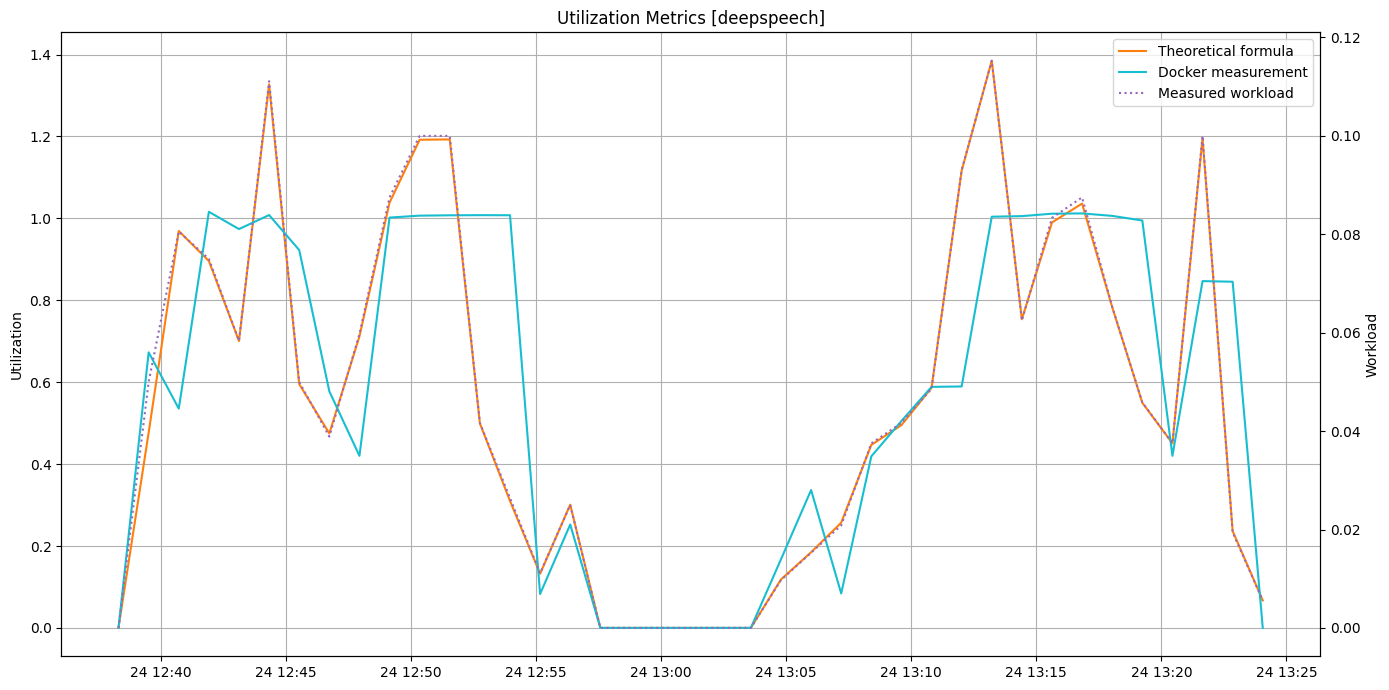

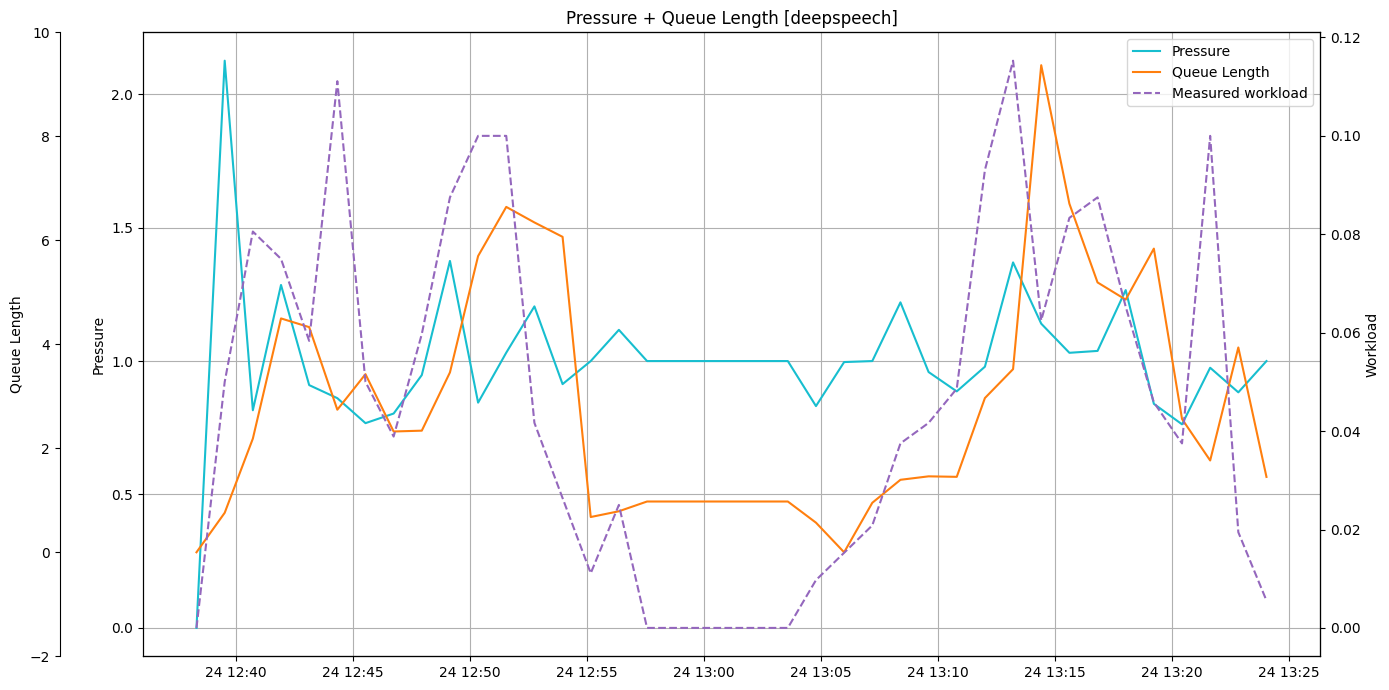

In [6]:
deepspeech_metrics = metrics_df[metrics_df['function'] == 'deepspeech']

plot_utilization(deepspeech_metrics, 'deepspeech')
plot_pressure_queue(deepspeech_metrics, 'deepspeech')